# Deep Learning - **Homework #3**

* Teching assistant email: trung@uef.fi
* Deadline: **23:59 - 14/12/2019 (UPDATED)**
* Maximum: **3 points**

Goals:

* Understand the important role of "randomization" in machine learning.
* Implement Radial Basis Function using your first customized `keras.layers.Layer` or `torch.nn.Module`.
* Admire Darwin and his theory with genetic algorithm and evolution strategy.

References:

1. Glorot, X., Bengio, Y., n.d. ["Understanding the difﬁculty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 8.
2. Broomhead, D. S.; Lowe, David (1988). ["Radial basis functions, multi-variable functional interpolation and adaptive networks"](http://www.dtic.mil/cgi-bin/GetTRDoc?AD=ADA196234) (Technical report).
3. Ha, David, 2017. ["A Visual Guide to Evolution Strategies"](http://blog.otoro.net/2017/10/29/visual-evolution-strategies/).

How to submit:

* Option#1: **File** $\to$ **Download .ipynb** $\to$ _Send to .ipynb file to my email, or submit it to moodle page_.
* Option#2: **Share** read-only notebook link to my email.
* _If you choose to share the notebook, please re-name the notebook to your student name and student number, I will take the snapshot of your notebook before the deadline, any modification afterward will be disregarded._

**NOTE**: This is official homework and will be graded

In [0]:
# All libraries we use for this HW, run this block first!
%tensorflow_version 2.x
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.ops import init_ops
np.random.seed(8)
tf.random.set_seed(8)

X_digit, y_digit = load_digits(return_X_y=True)
X_digit_train, X_digit_test, y_digit_train, y_digit_test = train_test_split(X_digit, y_digit, test_size=0.3)

# Question 1: A good initialization is the one that you never know


![alt text](https://drive.google.com/uc?export=view&id=15bvT51OngFUT96ru24IymHRyt2wBZVly)

The above figure illustrate the `crossentropy` loss surface in relation to the parameters of the network $W_1$ and $W_2$.

As you can see, by just randomly picking the initial values for the weights, we could land right at the optimum position.

With this _mindset_, answer question **a)** and **b)**

### **a)** Every randomization is _"equal"_, but some are more _"equal"_ than the others.

The back-propagated gradients were smaller as one moves away from the output layer [1]. 

As a result, the normalization factor may therefore be important when
initializing deep networks because of the multiplicative effect through layers [1]. 

A **normalized initialization** is proposed to maintain activation variances and back-propagated gradients variance as one moves up or down the network [1]. 

> In short, using equation **(16)** in the paper [1] to implement the normalized initialization in following code block.

**[1]** Glorot, X., Bengio, Y., n.d. [Understanding the difﬁculty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 8.


In [0]:
class Uniform(init_ops.Initializer):

  def __call__(self, shape, dtype=None, partition_info=None):
    return tf.random.uniform(shape=shape, minval=0, maxval=None, dtype=dtype)


class NormalizedUniform(init_ops.Initializer):

  def __call__(self, shape, dtype=None, partition_info=None):
    # SOLUTION: finish the implementation of NormalizedUniform initialization
    fan_in = shape[-2]
    fan_out = shape[-1]
    limit = tf.math.sqrt(6.0 / ((fan_in + fan_out) / 2.))
    return tf.random.uniform(shape=shape,
                             minval=-limit,
                             maxval=limit,
                             dtype=dtype)

Trained 5 different models with `Uniform` initialization
Trained 10 different models with `Uniform` initialization
Trained 5 different models with `NormalizedUniform` initialization
Trained 10 different models with `NormalizedUniform` initialization


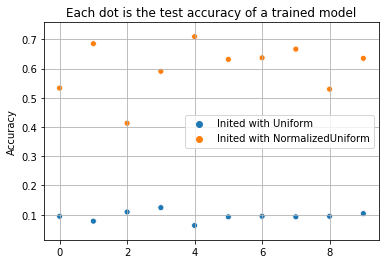

In [0]:
#@title Run the following code block to debug your initializer
def repeat_train_model(init_class):
  uniform_acc = []
  for i in range(10):
    model = keras.Sequential([
        keras.layers.Dense(64,
                           kernel_initializer=init_class(),
                           activation='relu'),
        keras.layers.Dense(64,
                           kernel_initializer=init_class(),
                           activation='relu'),
        keras.layers.Dense(10, activation='softmax'),
    ])
    model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
    # we intentionally only train the network
    # with 10 epochs to make it underfit
    model.fit(x=X_digit_train,
              y=y_digit_train,
              batch_size=512,
              epochs=10,
              verbose=0)
    y_test_pred = np.argmax(model.predict(X_digit_test), axis=-1)
    test_acc = accuracy_score(y_digit_test, y_test_pred)
    uniform_acc.append(test_acc)
    if (i + 1) % 5 == 0:
      print("Trained %d different models with `%s` initialization" %
            ((i + 1), init_class.__name__))
  return uniform_acc


uniform_acc = repeat_train_model(Uniform)
normuniform_acc = repeat_train_model(NormalizedUniform)
n = len(uniform_acc)
sns.scatterplot(x=list(range(n)) + list(range(n)),
                y=uniform_acc + normuniform_acc,
                hue=['Inited with Uniform'] * n +
                ['Inited with NormalizedUniform'] * n)
plt.grid(True)
plt.ylabel('Accuracy')
_ = plt.title("Each dot is the test accuracy of a trained model")

### **b)** Are every problem could be solved by repeating different initialization until you get the optimum solution?
----
We still have to fine-tune the output layer for specific task.

A randomized deep network could be good feature embedding for simple task. However, when the number of layers and number of features increasing, it becomes harder to get reasonable good initialization due to the curse of dimensionality.

# Question 2: Radial Basis Function (RBF)

The RBF neural networks implement the function:

$s(x) = b_0 + \sum_i^Mw_i\Phi\big( ||\vec{x} - \vec{c_i}|| \big) \tag{1}$

where:

* $b_0 \in \Re$ is the bias term 
* $w_i \in \Re$ is the weight value for neuron unit $i^{th}$
* $\vec{x} \in \Re^N$ is the input vector
* $\vec{c_i} \in \Re^N$ is the center of neuron unit $i^{th}$

The basis function

$\Phi(||\vec{x} - \vec{c_i}||) = exp\big(-\frac{||\vec{x} - \vec{c_i}||^2}{\beta^2}\big) \tag{2}$

and $||\vec{x} - \vec{c_i}|| = \sqrt{\sum(\vec{x} - \vec{c_i})^2}$

Design a RBF to approximate the following function:

$y = sin(x) \times cos(x), \text{ } 0 \leq x \leq 2\pi \tag{3}$





### **a)** Finish the following function to generate training and testing data for the RBF.

In [0]:
def generate_data(num_data_points=1000):
  x = np.linspace(0, 2 * np.pi, num=num_data_points)
  y = np.sin(x) * np.cos(x)
  return np.expand_dims(x, axis=1).astype('float32'), y.astype('float32')


x, y = generate_data()
assert x.ndim == 2, "Your input must be 2-D"
assert y.ndim == 1, "Your target must be 1-D"
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

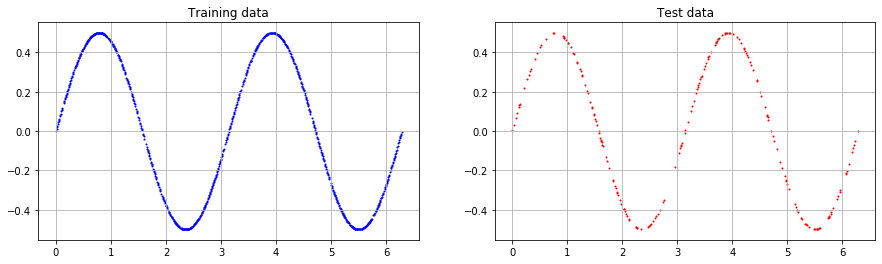

In [0]:
#@title Run this blog to debug your data generation
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, c='b', s=1)
plt.grid(True)
plt.title("Training data")
plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test, c='r', s=1)
plt.grid(True)
_ = plt.title("Test data")

### **b)** Finish the implementation of the `RadialBasisFunction` class

Did your *RBF* fit the data? (i.e. it provides a sinusoid curve in the prediction)

If not, could you explain why? (_Hint_: again the initialization is important)

---
`RadialBasisFunction` performance is sensitive to the initialization of the centers. If all centers are located in single area, the algorithm easily converges to local optima, and cannot spread the centers to cover all range of the output.

This is crucial. Since we cannot know the _range_ of unseen data, RBF might not generalized well.

In [0]:
class RadialBasisFunction(keras.layers.Layer):

  def __init__(self, units, center_initializer='glorot_uniform', beta=1.0):
    super().__init__()
    self.units = int(units)
    self.beta = beta
    self.center_initializer = center_initializer

  def build(self, input_shape):
    super().build(input_shape)
    input_dim = input_shape[-1]
    self.weight = self.add_weight('weight',
                                  shape=(self.units,),
                                  initializer='glorot_uniform',
                                  dtype=self.dtype,
                                  trainable=True)
    if isinstance(self.center_initializer, np.ndarray):
      self.center = self.add_weight('center',
                                    shape=(self.units, input_dim),
                                    initializer='zeros',
                                    dtype=self.dtype,
                                    trainable=True)
      self.center.assign(self.center_initializer)
    else:
      self.center = self.add_weight('center',
                                    shape=(self.units, input_dim),
                                    initializer=self.center_initializer,
                                    dtype=self.dtype,
                                    trainable=True)
    # single bias for all units
    self.bias = self.add_weight('bias',
                                shape=(1,),
                                initializer='zeros',
                                dtype=self.dtype,
                                trainable=True)

  def call(self, inputs):
    # need to expand dims to make inputs broadcastable to the center
    # We have something like these:
    # * inputs [batch_size, input_dim] -> [batch_size, 1, input_dim]
    # * center [units, input_dims]
    # * inputs-center [batch_size, units, input_dims]
    # * radius [batch_size, units]
    inputs = tf.expand_dims(inputs, axis=-2)
    radius = tf.norm(inputs - self.center, ord='euclidean', axis=-1)
    beta = tf.cast(self.beta, dtype=self.dtype)
    # [batch_size, units]
    outputs = self.weight * tf.math.exp(-tf.square(radius) / tf.square(beta))
    # [batch_size,]
    outputs = tf.reduce_sum(outputs + self.bias, axis=-1)
    return outputs

In [0]:
# run this block to create your rbf, you might modify it as necessary
centroids = np.expand_dims(np.linspace(0, 2 * np.pi, 8), axis=1)
rbf = RadialBasisFunction(units=8, beta=1.0, center_initializer=centroids)

Epoch#9  Loss:0.1772
Epoch#19  Loss:0.0852
Epoch#29  Loss:0.0444
Epoch#39  Loss:0.0269
Epoch#49  Loss:0.0165
Epoch#59  Loss:0.0112
Epoch#69  Loss:0.0089
Epoch#79  Loss:0.0074
Epoch#89  Loss:0.0062
Epoch#99  Loss:0.0053
Test Loss: 0.005347267


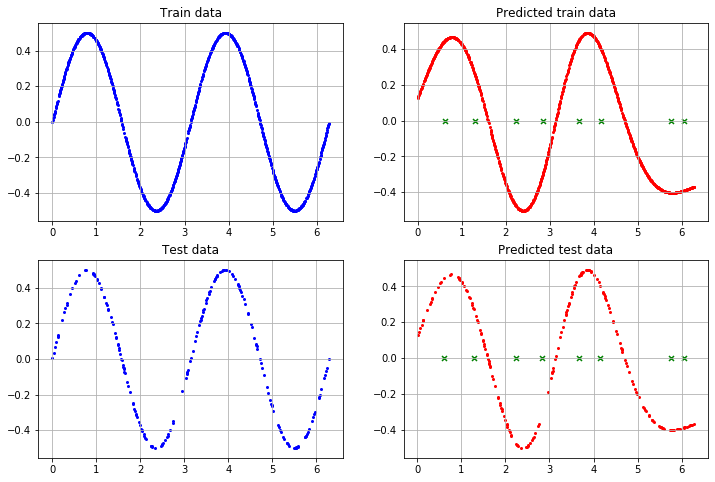

In [0]:
#@title Run the following code blog to use backpropagation training your rbf and debug it (NOTE: the green cross is the center of each neuron unit)
opt = tf.optimizers.Adam(learning_rate=0.01)
fn_loss = tf.losses.mean_squared_error
for epoch in range(100):
  with tf.GradientTape() as tape:
    y_train_pred = rbf(x_train)
    loss = fn_loss(y_train, y_train_pred)
  grads = tape.gradient(loss, rbf.trainable_weights)
  opt.apply_gradients(
      grads_and_vars=[(g, w) for g, w in zip(grads, rbf.trainable_weights)])
  if (epoch + 1) % 10 == 0:
    print("Epoch#%d  Loss:%.4f" % (epoch, loss))

y_test_pred = rbf(x_test)
print("Test Loss:", fn_loss(y_test, y_test_pred).numpy())

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")

# Question 3: Use genetic algorithm to train the network of Radial Basis Function.

![alt text](https://drive.google.com/uc?export=view&id=1XSFo1Ep5w0lll5_r3XewSxvDHhLPmxwT)

The above flow chart describes the genetic algorithm and the purpose of each function you have to implement in **a)**, **b)** and **c)** (only the `TODO` places)

### **a)** Finish the implementation of all essential functions for GA

In [0]:
def initialze_population(units, input_shape, size=100):
  # SOLUTION
  population = []
  for i in range(int(size)):
    rbf = RadialBasisFunction(units)
    rbf.build(input_shape)
    population.append(rbf)
  return population


def mutate(rbf, mean=0., stddev=1., mutation_rate=0.1):
  # TODO
  # concatenate all parameters into single vector, easier to handle
  params = tf.concat(
      [tf.reshape(rbf.weight, [-1]),
       tf.reshape(rbf.center, [-1]), rbf.bias],
      axis=0)
  noise = tf.random.normal(shape=params.shape,
                           mean=mean,
                           stddev=stddev,
                           dtype=params.dtype)
  mask = tf.random.uniform(shape=params.shape) < mutation_rate
  new_params = tf.where(mask, params + noise, params)
  rbf.weight.assign(tf.reshape(new_params[:rbf.units], rbf.weight.shape))
  rbf.center.assign(tf.reshape(new_params[rbf.units:-1], rbf.center.shape))
  rbf.bias.assign(tf.reshape(new_params[-1], rbf.bias.shape))


def crossover(rbf1, rbf2):
  rbf = RadialBasisFunction(units=rbf1.units)
  rbf.build(input_shape=(None, rbf1.center.shape[1]))
  # concatenate all parameters into single vector, easier to handle
  params1 = tf.concat(
      [tf.reshape(rbf1.weight, [-1]),
       tf.reshape(rbf1.center, [-1]), rbf1.bias],
      axis=0)
  params2 = tf.concat(
      [tf.reshape(rbf2.weight, [-1]),
       tf.reshape(rbf2.center, [-1]), rbf2.bias],
      axis=0)
  # new params inherit from both mum and dad
  new_params = (params1 + params2) / 2
  rbf.weight.assign(tf.reshape(new_params[:rbf.units], rbf.weight.shape))
  rbf.center.assign(tf.reshape(new_params[rbf.units:-1], rbf.center.shape))
  rbf.bias.assign(tf.reshape(new_params[-1], rbf.bias.shape))
  return rbf

def select(x_train,
           y_train,
           population,
           n_best=20,
           loss_func=tf.losses.mean_squared_error):
  # TODO
  losses = [
      tf.reduce_mean(loss_func(y_train, rbf(x_train))) for rbf in population
  ]
  # sort in ascending order
  sorted_indices = tf.argsort(losses, direction='ASCENDING')[:n_best]
  return [population[idx] for idx in sorted_indices],\
      [losses[idx] for idx in sorted_indices]

### **b)** Writing the training procedure for Genetic algorithm

In [0]:
def genetic_algorithm(crossover_func=crossover,
                      n_generation=80,
                      population_size=80,
                      n_best=20):
  population = initialze_population(8,
                                    input_shape=(None, 1),
                                    size=population_size)
  history = []
  best_rbf = None
  for generation in range(n_generation):
    best_candidates, best_losses = select(x_train,
                                          y_train,
                                          population,
                                          n_best=n_best)
    best_losses = np.asarray(best_losses)
    # The parents will be selected based how good they are,
    # determine the probabilities of each candidate here.
    # TODO
    candidates_probabilities = (best_losses / np.sum(best_losses))[::-1]

    # crossover create a new off-spring with mutation
    new_population = []
    for i in range(population_size):
      rbf1, rbf2 = np.random.choice(best_candidates,
                                    size=2,
                                    replace=False,
                                    p=candidates_probabilities)
      offspring = crossover_func(rbf1, rbf2)
      mutate(offspring, mean=0, stddev=1., mutation_rate=0.1)
      new_population.append(offspring)
    population = new_population
    # since losses is sorted in ascending order, the first one is the smallest
    # (i.e. the best) loss value
    if (generation + 1) % 5 == 0:
      print("Generation#%d  Loss:%.4f" % (generation + 1, best_losses[0]))
    history.append(best_losses[0])
    if best_losses[0] <= np.min(history):
      best_rbf = best_candidates[0]
  plt.figure()
  plt.plot(history)
  plt.title("Training Loss")
  return best_rbf

Generation#5  Loss:0.1004
Generation#10  Loss:0.0992
Generation#15  Loss:0.0962
Generation#20  Loss:0.0900
Generation#25  Loss:0.0902
Generation#30  Loss:0.0983
Generation#35  Loss:0.0982
Generation#40  Loss:0.0971
Generation#45  Loss:0.0912
Generation#50  Loss:0.0934
Generation#55  Loss:0.0933
Generation#60  Loss:0.0933
Generation#65  Loss:0.0881
Generation#70  Loss:0.0932
Generation#75  Loss:0.0908
Generation#80  Loss:0.0884


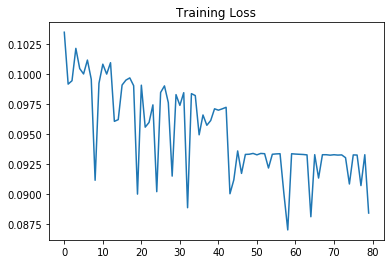

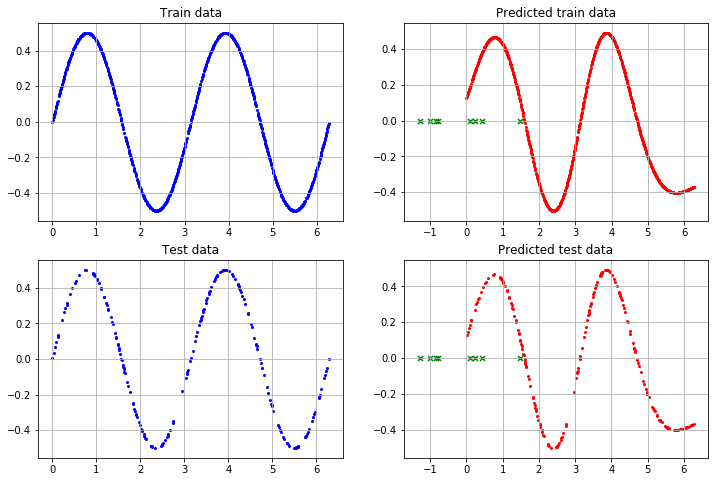

In [0]:
#@title Run this code block to debug your genetic algorithm
rbf = genetic_algorithm()
assert isinstance(rbf, RadialBasisFunction), "genetic_algorithm must return an instance of RadialBasisFunction class"
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")

### **c)** Something wrong with `crossover` function, could you fix it? Finish the implementation of `crossover_new`

**NOTE**: if the first `crossover` function is right, then Darwin must be wrong. 

---
The inheritant of genes must be specific, i.e. the child must inherit trait from dad or mum but not both.

This is crucial for evolution algorithm to work, since if the trait is calculated as average of both mum and dad, all member in the population will converge to single trait. As a result, diversity is trending down for generalization, and no one could "evolve".

In [0]:
def crossover_new(rbf1, rbf2):
  # Solution
  rbf = RadialBasisFunction(units=rbf1.units)
  rbf.build(input_shape=(None, rbf1.center.shape[1]))
  # concatenate all parameters into single vector, easier to handle
  params1 = tf.concat(
      [tf.reshape(rbf1.weight, [-1]),
       tf.reshape(rbf1.center, [-1]), rbf1.bias],
      axis=0)
  params2 = tf.concat(
      [tf.reshape(rbf2.weight, [-1]),
       tf.reshape(rbf2.center, [-1]), rbf2.bias],
      axis=0)
  mask = tf.random.uniform(shape=params1.shape) < 0.5
  new_params = tf.where(mask, params1, params2)
  rbf.weight.assign(tf.reshape(new_params[:rbf.units], rbf.weight.shape))
  rbf.center.assign(tf.reshape(new_params[rbf.units:-1], rbf.center.shape))
  rbf.bias.assign(tf.reshape(new_params[-1], rbf.bias.shape))
  return rbf

Generation#5  Loss:0.0979
Generation#10  Loss:0.0809
Generation#15  Loss:0.0801
Generation#20  Loss:0.0795
Generation#25  Loss:0.0736
Generation#30  Loss:0.0716
Generation#35  Loss:0.0705
Generation#40  Loss:0.0696
Generation#45  Loss:0.0694
Generation#50  Loss:0.0694
Generation#55  Loss:0.0694
Generation#60  Loss:0.0692
Generation#65  Loss:0.0682
Generation#70  Loss:0.0684
Generation#75  Loss:0.0684
Generation#80  Loss:0.0683


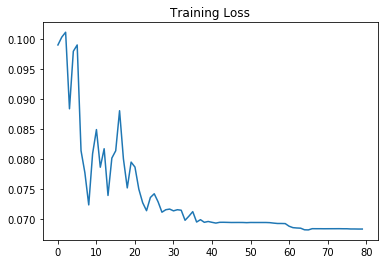

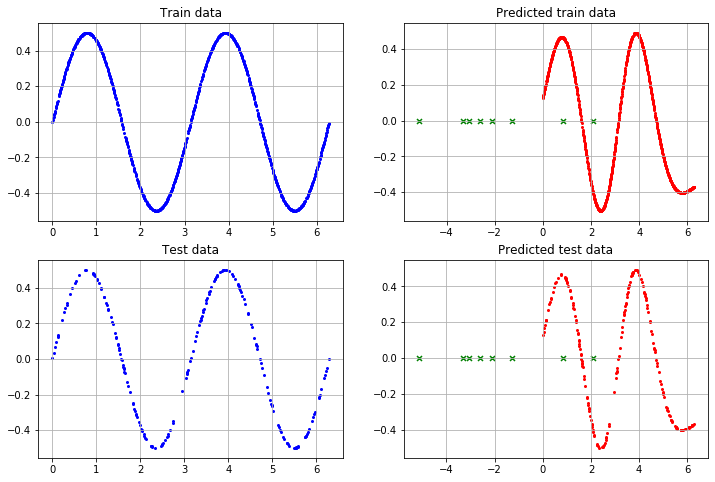

In [0]:
#@title Run this code block to debug your `crossover_new` function
rbf = genetic_algorithm(crossover_func=crossover_new)
assert isinstance(rbf, RadialBasisFunction), "genetic_algorithm must return an instance of RadialBasisFunction class"
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")